<a href="https://colab.research.google.com/github/nilum2002/-Game-Dodge-the-Falling-Blocks/blob/main/week03/training_vision_models_first_steps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title
# Download and Save MNIST as Images

from torchvision import datasets
import os

# Download MNIST
train_dataset = datasets.MNIST(root='./mnist_raw', train=True, download=True)
test_dataset = datasets.MNIST(root='./mnist_raw', train=False, download=True)

print(f"Downloaded {len(train_dataset)} train and {len(test_dataset)} test images\n")

# Save to folder structure
def save_to_folders(dataset, output_dir, split):
    for digit in range(10):
        os.makedirs(f'{output_dir}/{split}/{digit}', exist_ok=True)

    for idx, (image, label) in enumerate(dataset):
        image.save(f'{output_dir}/{split}/{label}/img_{idx:05d}.png')
        if (idx + 1) % 10000 == 0:
            print(f"Saved {idx + 1}/{len(dataset)} {split} images...")

save_to_folders(train_dataset, './mnist_data', 'train')
save_to_folders(test_dataset, './mnist_data', 'test')

print("\n✓ Images saved to mnist_data/train/ and mnist_data/test/")

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.57MB/s]


Downloaded 60000 train and 10000 test images

Saved 10000/60000 train images...
Saved 20000/60000 train images...
Saved 30000/60000 train images...
Saved 40000/60000 train images...
Saved 50000/60000 train images...
Saved 60000/60000 train images...
Saved 10000/10000 test images...

✓ Images saved to mnist_data/train/ and mnist_data/test/


In [ ]:
import torch
import torch.nn as nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Dataset, random_split
import matplotlib.pyplot as plt
import PIL.Image as Image
import os


##HELPER FUNCTIONS
def plot_training_loss(train_losses):
    """Plot training loss."""
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True, alpha=0.3)
    plt.show()


def evaluate_test(model, test_loader):
    """Evaluate model on test set."""
    # Check for GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            # Move data to device
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    test_accuracy = 100 * correct / total
    print(f"\n{'='*50}")
    print(f"TEST ACCURACY: {test_accuracy:.2f}%")
    print(f"{'='*50}")

    return test_accuracy


# PyTorch Dataset Class

## What is a Dataset?

In PyTorch, a **Dataset** is a class that represents your data. It tells PyTorch:
- How to load your data
- How many samples you have
- How to get a single sample

## The Dataset Contract

Every Dataset must implement 3 methods:

### 1. `__init__()` - Initialize
Set up your dataset (paths, transformations, etc.)

### 2. `__len__()` - Length
Return the total number of samples

### 3. `__getitem__(idx)` - Get Item
Return one sample (image, label) at index `idx`

## Simple Example:

```python
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        return image, label
```

## Why use Dataset?

✅ Works seamlessly with DataLoader (batching, shuffling)

✅ Standard interface for all data types

✅ Easy to add transformations (augmentation, normalization)

✅ Memory efficient (loads data on-demand)

Let's create a Dataset for vision!

# Loading Images from Folder Structure

## Real-World Image Datasets

In practice, image datasets are organized in folders like this:

```
data/
├── train/
│   ├── 0/
│   │   ├── img_001.png
│   │   ├── img_002.png
│   │   └── ...
│   ├── 1/
│   │   ├── img_001.png
│   │   └── ...
│   └── ...
└── test/
    ├── 0/
    ├── 1/
    └── ...
```

In [ ]:
class MNISTFromFolder(Dataset):
    """Custom Dataset to load MNIST images from folder structure."""

    def __init__(self, root_dir, split='train', transform=None):
        """
        Args:
            root_dir: Root directory (e.g., './mnist_data')
            split: 'train' or 'test'
            transform: Optional transformations
        """
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load all image paths and labels
        for class_idx in range(10):  # Classes 0-9
            class_dir = os.path.join(self.root_dir, str(class_idx))

            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(class_idx)

        print(f"Loaded {len(self.image_paths)} images from {self.root_dir}")

    def __len__(self):
        """Return total number of samples."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """Get one sample (image, label)."""
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale

        # Get label
        label = self.labels[idx]

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
])

# Create datasets
train_dataset = MNISTFromFolder('./mnist_data', split='train', transform=transform)
test_dataset = MNISTFromFolder('./mnist_data', split='test', transform=transform)

print(f"\nDataset sizes:")
print(f"  Training: {len(train_dataset)}")
print(f"  Test: {len(test_dataset)}")



Loaded 60000 images from ./mnist_data/train
Loaded 10000 images from ./mnist_data/test

Dataset sizes:
  Training: 60000
  Test: 10000


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

print(f"\nDataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Test: Get one batch
images, labels = next(iter(train_loader))
print(f"\nBatch shape:")
print(f"  Images: {images.shape}")  # [256, 1, 28, 28]
print(f"  Labels: {labels.shape}")  # [256]


DataLoaders created:
  Train batches: 235
  Test batches: 40

Batch shape:
  Images: torch.Size([256, 1, 28, 28])
  Labels: torch.Size([256])


Batch shape: torch.Size([256, 1, 28, 28])
Labels shape: torch.Size([256])


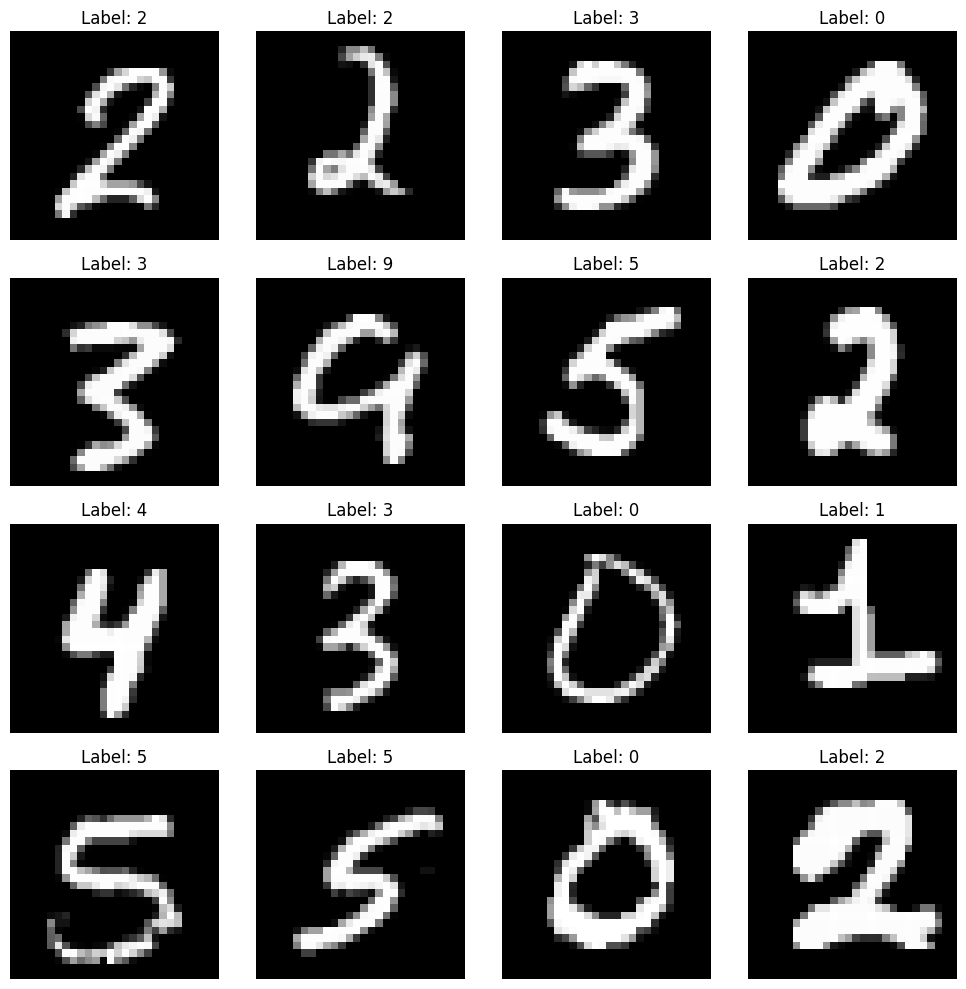

In [ ]:
# Get first batch
images, labels = next(iter(train_loader))

print(f"Batch shape: {images.shape}")  # [256, 1, 28, 28]
print(f"Labels shape: {labels.shape}")  # [256]

# Plot first 16 images from the batch
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for i in range(16):
    img = images[i].squeeze()  # Remove channel dimension [1, 28, 28] -> [28, 28]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'Label: {labels[i].item()}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Fully Connected Neural Network

## Starting Simple: Flatten the Images

Before we use CNNs, let's start with a simple **fully connected network**.

### The Process:
1. **Flatten** the image: [1, 28, 28] → [784]
   - 28 × 28 = 784 pixels
2. **Feed to network**: Input → Hidden → Hidden → Output
3. **Use ReLU** activation for non-linearity

### Network Architecture:
```
Input Layer:  784 neurons (flattened 28×28 image)
      ↓
Hidden Layer 1: 128 neurons + ReLU
      ↓
Hidden Layer 2: 64 neurons + ReLU
      ↓
Output Layer: 10 neurons (digits 0-9)
```

### Why start with this?
- Simpler than CNNs
- Shows the baseline performance
- Later, we'll see how CNNs improve on this!

Let's build it!

In [ ]:
class FlattenNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        # Hidden layers
        self.hidden1 = nn.Linear(28*28, 128)  # Hidden layer 1
        self.relu1 = nn.ReLU()
        self.hidden2 = nn.Linear(128, 64)     # Hidden layer 2
        self.relu2 = nn.ReLU()

        # Output layer
        self.output = nn.Linear(64, 10)       # Output layer (10 classes)

    def forward(self, x):
        # Input: [batch, 1, 28, 28]
        x = self.flatten(x)      # → [batch, 784] (input to network)

        # Hidden layer 1
        x = self.hidden1(x)      # → [batch, 128]
        x = self.relu1(x)

        # Hidden layer 2
        x = self.hidden2(x)      # → [batch, 64]
        x = self.relu2(x)

        # Output layer
        x = self.output(x)       # → [batch, 10] (logits)
        return x

# Create model
model = FlattenNetwork()

print("Model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Model architecture:
FlattenNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
)

Total parameters: 109,386


In [ ]:
def train_model(model, train_loader, num_epochs=10, lr=0.001):
    """
    Train model and track loss.

    Args:
        model: PyTorch model
        train_loader: Training DataLoader
        num_epochs: Number of epochs
        lr: Learning rate

    Returns:
        train_losses: List of training losses per epoch
    """
    # Check for GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}\n")

    # Move model to device
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []

    print(f"Training for {num_epochs} epochs...\n")

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for batch_x, batch_y in train_loader:
            # Move data to device
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Average training loss
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f}")

    print("\nTraining complete!")
    return train_losses

In [ ]:
len(train_loader)

235

Using device: cuda

Training for 20 epochs...

Epoch [1/20] | Loss: 0.5429
Epoch [2/20] | Loss: 0.2188
Epoch [3/20] | Loss: 0.1589
Epoch [4/20] | Loss: 0.1250
Epoch [5/20] | Loss: 0.1014
Epoch [6/20] | Loss: 0.0831
Epoch [7/20] | Loss: 0.0693
Epoch [8/20] | Loss: 0.0601
Epoch [9/20] | Loss: 0.0507
Epoch [10/20] | Loss: 0.0437
Epoch [11/20] | Loss: 0.0379
Epoch [12/20] | Loss: 0.0307
Epoch [13/20] | Loss: 0.0265
Epoch [14/20] | Loss: 0.0237
Epoch [15/20] | Loss: 0.0208
Epoch [16/20] | Loss: 0.0168
Epoch [17/20] | Loss: 0.0152
Epoch [18/20] | Loss: 0.0134
Epoch [19/20] | Loss: 0.0104
Epoch [20/20] | Loss: 0.0106

Training complete!


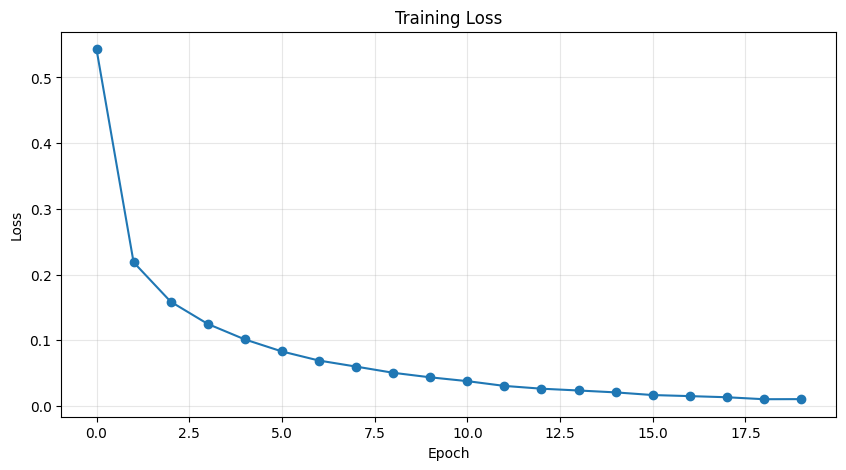


TEST ACCURACY: 97.78%


In [ ]:
#LETS GOOOOO
model = FlattenNetwork()
losses = train_model(model, train_loader, num_epochs=20)
plot_training_loss(losses)
test_acc = evaluate_test(model, test_loader)

Using device: cuda

Training for 20 epochs...

Epoch [1/20] | Loss: 0.4972
Epoch [2/20] | Loss: 0.0781
Epoch [3/20] | Loss: 0.0592
Epoch [4/20] | Loss: 0.0481
Epoch [5/20] | Loss: 0.0403
Epoch [6/20] | Loss: 0.0331
Epoch [7/20] | Loss: 0.0294
Epoch [8/20] | Loss: 0.0239
Epoch [9/20] | Loss: 0.0209
Epoch [10/20] | Loss: 0.0173
Epoch [11/20] | Loss: 0.0148
Epoch [12/20] | Loss: 0.0131
Epoch [13/20] | Loss: 0.0113
Epoch [14/20] | Loss: 0.0096
Epoch [15/20] | Loss: 0.0077
Epoch [16/20] | Loss: 0.0063
Epoch [17/20] | Loss: 0.0063
Epoch [18/20] | Loss: 0.0042
Epoch [19/20] | Loss: 0.0056
Epoch [20/20] | Loss: 0.0028

Training complete!


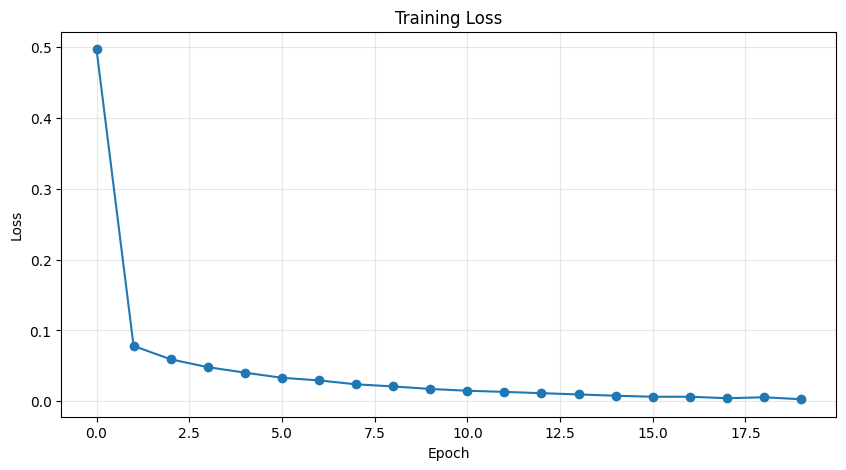


TEST ACCURACY: 41.02%


In [ ]:
#lets show the overfitting by making the training dataset small
from torch.utils.data import Subset
small_dataset = Subset(train_dataset, range(20000))
train_loader_small = DataLoader(small_dataset, batch_size=256, shuffle=True)


#LETS GOOOOO
model = FlattenNetwork()
losses = train_model(model, train_loader_small, num_epochs=20)
plot_training_loss(losses)
test_acc = evaluate_test(model, test_loader)

## Lets do it right

In [ ]:
from torch.utils.data import random_split

# Split train into 80% train, 20% valid
train_size = int(0.8 * len(small_dataset))
valid_size = len(small_dataset) - train_size

train_data, valid_data = random_split(small_dataset, [train_size, valid_size])

# Create DataLoaders
train_loader_small = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader_small = DataLoader(valid_data, batch_size=64, shuffle=False)

print(f"Train: {len(train_data)}, Valid: {len(valid_data)}")

Train: 16000, Valid: 4000


In [ ]:
def train_with_validation(model, train_loader, valid_loader, num_epochs=10, lr=0.001):
    """
    Train model and track train and validation loss.

    Args:
        model: PyTorch model
        train_loader: Training DataLoader
        valid_loader: Validation DataLoader
        num_epochs: Number of epochs
        lr: Learning rate

    Returns:
        train_losses: Training losses per epoch
        valid_losses: Validation losses per epoch
    """
    # Check for GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}\n")
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    valid_losses = []

    print(f"Training for {num_epochs} epochs...\n")

    for epoch in range(num_epochs):
        # ==================== Training ====================
        model.train()
        train_loss = 0

        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # ==================== Validation ====================
        model.eval()
        valid_loss = 0

        with torch.no_grad():
            for batch_x, batch_y in valid_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                valid_loss += loss.item()

        avg_valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Valid Loss: {avg_valid_loss:.4f}")

    print("\nTraining complete!")
    return train_losses, valid_losses


def plot_losses(train_losses, valid_losses):
    """Plot training and validation loss."""
    plt.figure(figsize=(10, 6))

    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, marker='o', label='Train Loss')
    plt.plot(epochs, valid_losses, marker='s', label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


Using device: cuda

Training for 20 epochs...

Epoch [1/20] | Train Loss: 0.2418 | Valid Loss: 0.0704
Epoch [2/20] | Train Loss: 0.0546 | Valid Loss: 0.0534
Epoch [3/20] | Train Loss: 0.0394 | Valid Loss: 0.0478
Epoch [4/20] | Train Loss: 0.0308 | Valid Loss: 0.0357
Epoch [5/20] | Train Loss: 0.0233 | Valid Loss: 0.0367
Epoch [6/20] | Train Loss: 0.0162 | Valid Loss: 0.0338
Epoch [7/20] | Train Loss: 0.0131 | Valid Loss: 0.0472
Epoch [8/20] | Train Loss: 0.0098 | Valid Loss: 0.0376
Epoch [9/20] | Train Loss: 0.0075 | Valid Loss: 0.0371
Epoch [10/20] | Train Loss: 0.0048 | Valid Loss: 0.0360
Epoch [11/20] | Train Loss: 0.0030 | Valid Loss: 0.0367
Epoch [12/20] | Train Loss: 0.0024 | Valid Loss: 0.0422
Epoch [13/20] | Train Loss: 0.0019 | Valid Loss: 0.0478
Epoch [14/20] | Train Loss: 0.0036 | Valid Loss: 0.0487
Epoch [15/20] | Train Loss: 0.0084 | Valid Loss: 0.0377
Epoch [16/20] | Train Loss: 0.0023 | Valid Loss: 0.0377
Epoch [17/20] | Train Loss: 0.0015 | Valid Loss: 0.0432
Epoch [18/

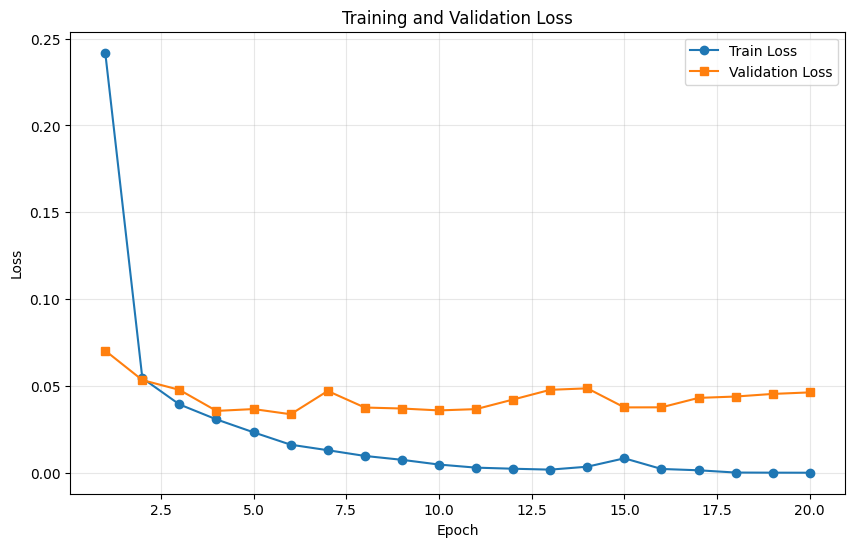

In [ ]:
#LETS GOOOOO
model = FlattenNetwork()
train_losses, valid_losses = train_with_validation(model, train_loader_small, valid_loader_small, num_epochs=20)
plot_losses(train_losses, valid_losses)

Train: 48000, Valid: 12000
Using device: cuda

Training for 10 epochs...

Epoch [1/10] | Train Loss: 0.3760 | Valid Loss: 0.1984
Epoch [2/10] | Train Loss: 0.1575 | Valid Loss: 0.1462
Epoch [3/10] | Train Loss: 0.1092 | Valid Loss: 0.1183
Epoch [4/10] | Train Loss: 0.0817 | Valid Loss: 0.1137
Epoch [5/10] | Train Loss: 0.0645 | Valid Loss: 0.1055
Epoch [6/10] | Train Loss: 0.0514 | Valid Loss: 0.0970
Epoch [7/10] | Train Loss: 0.0412 | Valid Loss: 0.0966
Epoch [8/10] | Train Loss: 0.0332 | Valid Loss: 0.0937
Epoch [9/10] | Train Loss: 0.0290 | Valid Loss: 0.1003
Epoch [10/10] | Train Loss: 0.0213 | Valid Loss: 0.1213

Training complete!


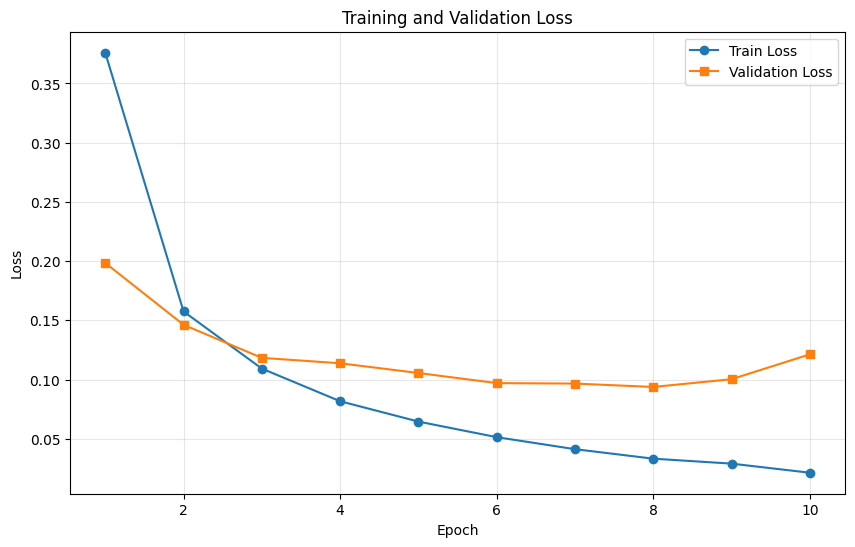

In [ ]:
# Split train into 80% train, 20% valid
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size

train_data, valid_data = random_split(train_dataset, [train_size, valid_size])

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=False)

print(f"Train: {len(train_data)}, Valid: {len(valid_data)}")



#LETS GOOOOO
model = FlattenNetwork()
train_losses, valid_losses = train_with_validation(model, train_loader, valid_loader, num_epochs=10)
plot_losses(train_losses, valid_losses)